### Explore how to build a spam detector

In [1]:
from __future__ import division, print_function, unicode_literals
import numpy as np
import pandas as pd
import os

np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


## Load data

In [2]:
import sys

from sys import platform
if platform == 'linux':
    DATA_PATH = os.path.join("/home/alin/handson-ml/datasets", "spamham")
else:
    DATA_PATH = os.path.join('C:/Users/alin/Documents/SelfStudy/datasets', 'spamham')

In [3]:
%qtconsole

In [4]:
EASY_HAM_PATH = os.path.join(DATA_PATH, 'easy_ham')
HARD_HAM_PATH = os.path.join(DATA_PATH, 'hard_ham')
SPAM_PATH = os.path.join(DATA_PATH, 'spam')

In [5]:
def load_one_email(filepath):
    with open(filepath, 'r', encoding='latin-1') as fpr:
            return fpr.read()

In [6]:
spam_data = {'ID':[], 'Email':[], 'Label':[]}

for filename in  os.listdir(EASY_HAM_PATH):
    spam_data['ID'].append(filename)
    spam_data['Label'].append(0)
    spam_data['Email'].append(load_one_email(os.path.join(EASY_HAM_PATH, filename)))
   

for filename in  os.listdir(HARD_HAM_PATH):
    spam_data['ID'].append(filename)
    spam_data['Label'].append(0)
    spam_data['Email'].append(load_one_email(os.path.join(HARD_HAM_PATH, filename)))

for filename in  os.listdir(SPAM_PATH):
    spam_data['ID'].append(filename)
    spam_data['Label'].append(1)
    spam_data['Email'].append(load_one_email(os.path.join(SPAM_PATH, filename)))

In [7]:
spam_df = pd.DataFrame(spam_data)

X = spam_df['Email']
y = spam_df['Label']

In [8]:
shuffle_index = np.random.permutation(y.shape[0])
X, y = X[shuffle_index], y[shuffle_index]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=42)

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.pipeline import Pipeline

import email

from sklearn.base import BaseEstimator, TransformerMixin

In [10]:
def remove_header(x):
    payload = email.message_from_string(x).get_payload()
    # if payload is not a string, set it to ''
    clean_txt = payload if isinstance(payload, str) else ''
    return clean_txt

class HeaderRemover(BaseEstimator, TransformerMixin):
    def __init__(self, header_remove=True):
        self.header_remove = header_remove
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        if self.header_remove:
            return X.apply(remove_header)
        else:
            return X

In [11]:
class UrlCleaner(BaseEstimator, TransformerMixin):
    def __init__(self, url_clean=True):
        self.url_clean = url_clean
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        if self.url_clean:
            return X.str.replace('https?://\S*', 'URL')
        else:
            return X

In [12]:
class NumCleaner(BaseEstimator, TransformerMixin):
    def __init__(self, num_clean=True):
        self.num_clean = num_clean
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        if self.num_clean:
            return X.str.replace('[-\+\d\.,]+', ' NUM ')
        else:
            return X

In [14]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
analyzer = CountVectorizer().build_analyzer()
def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))


In [15]:
def process_pipeline(header_remove=True, url_clean=True, num_clean=True, stem=False, stop_words = 'english', lowercase=True, strip_accents = True,
                     binary=True):
    pipe_items = []
    if strip_accents:
        accents = 'unicode'
    else:
        accents = None
    if stem:
        analyzer = stemmed_words
    else:
        analyzer = 'word'
    spam_pipeline = Pipeline([
        ('header_remover', HeaderRemover(header_remove=header_remove)),
        ('url_clean', UrlCleaner(url_clean=url_clean)),
        ('num_clean', NumCleaner(num_clean=num_clean)),
        ('vect', CountVectorizer(lowercase=lowercase, strip_accents=accents, analyzer = analyzer, stop_words=stop_words, binary=binary)),
    
    ])
   
    return spam_pipeline

In [66]:
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [97]:
pline = process_pipeline(url_clean=False, stem=True)

In [98]:
X_train0 = pline.fit_transform(X_train)


In [17]:
from sklearn.linear_model import SGDClassifier

In [62]:
from sklearn.model_selection import cross_val_score

In [77]:
from sklearn.model_selection import GridSearchCV

In [84]:
sgd_clf = SGDClassifier(random_state=42)


/home/alin/.pyenv/versions/3.6.2/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [89]:
def evaluate(model, X_tr, y_tr, cv=5):
    print(np.mean(cross_val_score(model, X_tr, y_tr, cv=cv, scoring='f1')))
    print(np.mean(cross_val_score(model, X_tr, y_tr, cv=cv, scoring='precision')))
    print(np.mean(cross_val_score(model, X_tr, y_tr, cv=cv, scoring='recall')))


In [99]:
evaluate(sgd_clf, X_train0, y_train)

0.866942256082
0.970195808825
0.784615384615


In [100]:
X_test0 = pline.transform(X_test)

In [103]:
evaluate(sgd_clf, X_test0, y_test)

0.815595306283
0.944818936686
0.721746031746


In [90]:
evaluate(sgd_clf, X_train0, y_train)

0.856546861443
0.959084076843
0.775384615385


In [67]:
logr = LogisticRegression()

In [68]:
evaluate(logr, X_train0, y_train)

[ 0.87179487  0.80357143  0.85217391  0.84210526  0.84210526]
[ 0.98076923  0.95744681  0.98        0.97959184  0.97959184]
[ 0.78461538  0.69230769  0.75384615  0.73846154  0.73846154]


In [80]:
rf = RandomForestClassifier(n_estimators=500, max_depth=60)

In [81]:
evaluate(rf, X_train0, y_train)

[ 0.81081081  0.75471698  0.76635514  0.77777778  0.78899083]
[ 0.97826087  1.          1.          0.97727273  0.97674419]
[ 0.69230769  0.61538462  0.63076923  0.66153846  0.63076923]


### grid search rf

In [ ]:
param_grid = {}

## Explore

In [20]:
from sklearn.model_selection import cross_val_score

In [35]:
from sklearn.model_selection import cross_val_predict

In [22]:
cross_val_score(sgd_clf, X_train0, y_train, cv=5, scoring='accuracy')

array([ 0.96162528,  0.96388262,  0.96606335,  0.9638009 ,  0.95248869])

In [26]:
sgd_clf.fit(X_train0, y_train)

X_test0 = pline.transform(X_test)
y_pred = sgd_clf.predict(X_test0)

In [27]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.947706422018


In [28]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [29]:
print(precision_score(y_test, y_pred))

0.983739837398


In [30]:
print(recall_score(y_test, y_pred))

0.6875


In [31]:
print(f1_score(y_test, y_pred))

0.809364548495


In [32]:
cross_val_score(sgd_clf, X_train0, y_train, cv=5, scoring='f1')

array([ 0.85950413,  0.86206897,  0.86956522,  0.86440678,  0.81415929])

In [33]:
cross_val_score(sgd_clf, X_train0, y_train, cv=5, scoring='precision')

array([ 0.92857143,  0.98039216,  1.        ,  0.96226415,  0.95833333])

In [34]:
cross_val_score(sgd_clf, X_train0, y_train, cv=5, scoring='recall')

array([ 0.8       ,  0.76923077,  0.76923077,  0.78461538,  0.70769231])

In [36]:
y_scores = cross_val_predict(sgd_clf, X_train0, y_train, cv=5, method="decision_function")

In [44]:
y_scores = y_scores[:,1]

In [41]:
from sklearn.metrics import precision_recall_curve

In [47]:
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

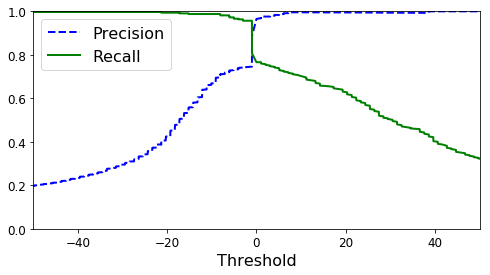

In [55]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-50, 50])
#save_fig("precision_recall_vs_threshold_plot")
plt.show()

In [56]:
from sklearn.metrics import roc_curve


In [57]:
fpr, tpr, threholds = roc_curve(y_train, y_scores)

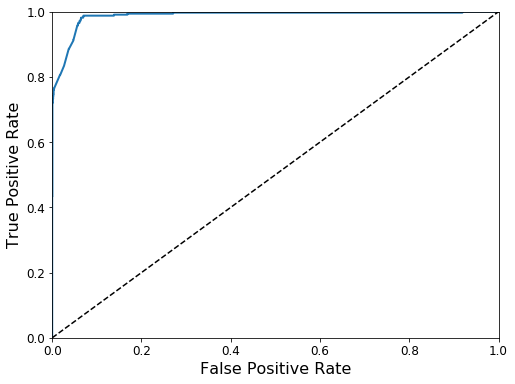

In [58]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
#save_fig("roc_curve_plot")
plt.show()

In [59]:
from sklearn.metrics import roc_auc_score

In [60]:
roc_auc_score(y_train, y_scores)

0.98704088704088699